In [1]:
import numpy as np
import cv2
from pathlib import Path
from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump, load
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import os
import gc


In [7]:
# configs
DATA_DIR = Path("../data/OCT2017 /train")
VAL_DIR = Path("../data/OCT2017 /val")
TEST_DIR = Path("../data/OCT2017 /test")
TARGET_SIZE = 128
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
BATCH_SIZE = 64
RANDOM_STATE = 192

In [8]:
# dataloader etc
def load_and_preprocess_image(path, target_size=TARGET_SIZE):
    img = Image.open(path).convert("RGB")
    w, h = img.size
    scale = target_size / max(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    img = img.resize((new_w, new_h), Image.LANCZOS)
    canvas = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    canvas.paste(img, ((target_size - new_w) // 2, (target_size - new_h) // 2))
    return np.asarray(canvas)


def enumerate_paths_and_labels(base_dir=DATA_DIR):
    classes = sorted([d.name for d in base_dir.iterdir() if d.is_dir()])
    label_map = {name: idx for idx, name in enumerate(classes)}
    paths, labels = [], []
    for name in classes:
        for p in sorted((base_dir / name).glob("*")):
            if p.suffix.lower() in IMG_EXTS:
                paths.append(p)
                labels.append(label_map[name])
    y = np.array(labels, dtype=np.int64)
    return paths, y, label_map



def batch_iterator(paths, indices=None, batch_size=BATCH_SIZE):
    if indices is None:
        indices = np.arange(len(paths))
    n = len(indices)
    for i in range(0, n, batch_size):
        idxs = indices[i:i + batch_size]
        imgs = [load_and_preprocess_image(paths[j]) for j in idxs]
        yield np.stack(imgs), idxs


# HOG
class HOGTransformer(BaseEstimator, TransformerMixin):
    """
    Converts (N, H, W, 3) uint8 images -> (N, F) HOG feature vectors (float64).
    """

    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm="L2-Hys",
                 visualize=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        self.visualize = visualize

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feats = []
        for img in X:
            g = rgb2gray(img.astype(np.float32) / 255.0)
            f = hog(
                g,
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                block_norm=self.block_norm,
                feature_vector=True
            )
            feats.append(f)
        return np.vstack(feats)

    def transform_with_viz(self, img_single):
        """Return (features, hog_image) for one image, to visualize in the PDF."""
        g = rgb2gray(img_single.astype(np.float32) / 255.0)
        f, hog_img = hog(
            g,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            block_norm=self.block_norm,
            visualize=True,
            feature_vector=True
        )
        return f, hog_img


# SIFT
class SIFTTransformer(BaseEstimator, TransformerMixin):
    """
    Extracts SIFT descriptors per image and pools to a fixed-length vector:
        feature = concat(mean(desc, axis=0), std(desc, axis=0), [count])
    Resulting dimension = 128 + 128 + 1 = 257
    """

    def __init__(self, n_features=0, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6):
        self.n_features = n_features
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.sigma = sigma
        self._sift = None

    def _ensure_sift(self):
        if self._sift is None:
            if not hasattr(cv2, "SIFT_create"):
                raise RuntimeError(
                    "SIFT not available in your OpenCV build. Install `opencv-contrib-python`."
                )
            self._sift = cv2.SIFT_create(
                nfeatures=self.n_features,
                contrastThreshold=self.contrastThreshold,
                edgeThreshold=self.edgeThreshold,
                sigma=self.sigma
            )

    def fit(self, X, y=None):
        self._ensure_sift()
        return self

    def _img_to_gray(self, img):
        if img.ndim == 3 and img.shape[2] == 3:
            return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return img

    def transform(self, X):
        self._ensure_sift()
        out = []
        for img in X:
            g = self._img_to_gray(img)
            kps, desc = self._sift.detectAndCompute(g, None)
            if desc is None or len(desc) == 0:
                mean = np.zeros(128, dtype=np.float32)
                std = np.zeros(128, dtype=np.float32)
                count = 0.0
            else:
                mean = desc.mean(axis=0)
                std = desc.std(axis=0)
                count = float(len(desc))
            vec = np.concatenate([mean, std, np.array([count], dtype=np.float32)], axis=0)
            out.append(vec.astype(np.float32))
        return np.vstack(out)

    def detect_keypoints(self, img_single):
        """Return keypoints for visualization purposes."""
        self._ensure_sift()
        g = self._img_to_gray(img_single)
        kps = self._sift.detect(g, None)
        return kps


# HOG+SIFT
class HOGSIFTConcatTransformer(BaseEstimator, TransformerMixin):
    """
    Computes HOG and SIFT features, then concatenates them:
      X -> [HOG(X) | SIFT(X)]
    Optional per-branch weights let you emphasize one feature family.
    """

    def __init__(
            self,
            hog_params=None,
            sift_params=None,
            hog_weight=1.0,
            sift_weight=1.0,
    ):
        self.hog_params = hog_params or {}
        self.sift_params = sift_params or {}
        self.hog_weight = float(hog_weight)
        self.sift_weight = float(sift_weight)
        self._hog = HOGTransformer(**self.hog_params)
        self._sift = SIFTTransformer(**self.sift_params)

    def fit(self, X, y=None):
        self._hog.fit(X, y)
        self._sift.fit(X, y)
        return self

    def transform(self, X):
        H = self._hog.transform(X).astype(np.float32, copy=False)
        S = self._sift.transform(X).astype(np.float32, copy=False)
        if self.hog_weight != 1.0:
            H = H * self.hog_weight
        if self.sift_weight != 1.0:
            S = S * self.sift_weight
        return np.hstack([H, S]).astype(np.float32, copy=False)


In [11]:
# Load training data
print("Loading training dataset paths and labels...")
paths, y, label_map = enumerate_paths_and_labels(DATA_DIR)
print(f"Total training samples: {len(paths)}")
print(f"Classes: {label_map}")
print(f"Class distribution: {np.bincount(y)}")

# Load evaluation set (val + test merged)
print("\nLoading evaluation dataset (val + test merged)...")
val_paths, y_val_set, _ = enumerate_paths_and_labels(VAL_DIR)
test_paths, y_test_set, _ = enumerate_paths_and_labels(TEST_DIR)

eval_paths = val_paths + test_paths
y_eval = np.concatenate([y_val_set, y_test_set])
print(f"Total evaluation samples: {len(eval_paths)} (val: {len(val_paths)}, test: {len(test_paths)})")
print(f"Evaluation distribution: {np.bincount(y_eval)}")

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"\nClass weights: {class_weight_dict}")

# Split training data into train (80%) and validation (20%)
train_idx, val_idx = train_test_split(
    np.arange(len(paths)),
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

y_train = y[train_idx]
y_val = y[val_idx]

print(f"\n--- Training Split ---")
print(f"Train samples (80%): {len(train_idx)}")
print(f"Train distribution: {np.bincount(y_train)}")
print(f"Val samples (20%): {len(val_idx)}")
print(f"Val distribution: {np.bincount(y_val)}")

# Load training data (80%) in batches
print("\nLoading training images (80%)...")
X_train_list = []
for batch_imgs, batch_idxs in tqdm(
        batch_iterator(paths, train_idx, batch_size=BATCH_SIZE),
        total=(len(train_idx) + BATCH_SIZE - 1) // BATCH_SIZE,
        desc="Loading train"
):
    X_train_list.append(batch_imgs)

X_train = np.concatenate(X_train_list, axis=0)
print(f"X_train shape: {X_train.shape}")
del X_train_list
gc.collect()

# Load validation data (20%) in batches
print("\nLoading validation images (20%)...")
X_val_list = []
for batch_imgs, batch_idxs in tqdm(
        batch_iterator(paths, val_idx, batch_size=BATCH_SIZE),
        total=(len(val_idx) + BATCH_SIZE - 1) // BATCH_SIZE,
        desc="Loading val"
):
    X_val_list.append(batch_imgs)

X_val = np.concatenate(X_val_list, axis=0)
print(f"X_val shape: {X_val.shape}")
del X_val_list
gc.collect()

# Build pipeline with specified HOG parameters
print("\nBuilding pipeline...")
pipeline = Pipeline([
    ('hog', HOGTransformer(
        orientations=12,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=256, random_state=RANDOM_STATE)),
    ('svm', LinearSVC(
        C=0.25,
        class_weight=class_weight_dict,
        max_iter=5000,
        random_state=RANDOM_STATE,
        dual='auto'
    ))
])

# Train the model on 80% of training data
print("\n" + "=" * 60)
print("TRAINING MODEL")
print("=" * 60)
start_time = time.time()
pipeline.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f}s")

# Evaluate on training set (20% holdout)
print("\n" + "=" * 60)
print("EVALUATION ON TRAINING HOLDOUT (20%)")
print("=" * 60)
y_val_pred = pipeline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

print("\nClassification Report (Training Holdout):")
print(classification_report(y_val, y_val_pred,
                            target_names=[name for name, _ in sorted(label_map.items(), key=lambda x: x[1])]))

# Save the model
model_save_path = "best_oct_model.joblib"
print(f"\nSaving model to {model_save_path}...")
dump(pipeline, model_save_path)
print("Model saved successfully!")


Loading training dataset paths and labels...
Total training samples: 83484
Classes: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
Class distribution: [37205 11348  8616 26315]

Loading evaluation dataset (val + test merged)...
Total evaluation samples: 1000 (val: 32, test: 968)
Evaluation distribution: [250 250 250 250]

Class weights: {0: np.float64(0.5609729875016799), 1: np.float64(1.8391787099048291), 2: np.float64(2.4223537604456826), 3: np.float64(0.7931217936538096)}

--- Training Split ---
Train samples (80%): 66787
Train distribution: [29764  9078  6893 21052]
Val samples (20%): 16697
Val distribution: [7441 2270 1723 5263]

Loading training images (80%)...


Loading train: 100%|██████████| 1044/1044 [04:23<00:00,  3.96it/s]


X_train shape: (66787, 128, 128, 3)

Loading validation images (20%)...


Loading val: 100%|██████████| 261/261 [01:05<00:00,  3.98it/s]


X_val shape: (16697, 128, 128, 3)

Building pipeline...

TRAINING MODEL
Training completed in 103.96s

EVALUATION ON TRAINING HOLDOUT (20%)
Validation Accuracy: 0.7833

Classification Report (Training Holdout):
              precision    recall  f1-score   support

         CNV       0.87      0.88      0.87      7441
         DME       0.73      0.71      0.72      2270
      DRUSEN       0.45      0.41      0.43      1723
      NORMAL       0.78      0.80      0.79      5263

    accuracy                           0.78     16697
   macro avg       0.71      0.70      0.70     16697
weighted avg       0.78      0.78      0.78     16697


Saving model to best_oct_model.joblib...
Model saved successfully!



LOADING EVALUATION SET (VAL + TEST MERGED)


Loading eval: 100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


X_eval shape: (1000, 128, 128, 3)

FINAL EVALUATION ON TEST SET (VAL + TEST MERGED)
Test Accuracy: 0.6960

Classification Report:
              precision    recall  f1-score   support

         CNV       0.55      0.96      0.70       250
         DME       0.97      0.29      0.44       250
      DRUSEN       0.77      0.58      0.66       250
      NORMAL       0.80      0.95      0.86       250

    accuracy                           0.70      1000
   macro avg       0.77      0.70      0.67      1000
weighted avg       0.77      0.70      0.67      1000


F1 Scores:
  Micro F1:    0.6960
  Macro F1:    0.6684
  Weighted F1: 0.6684

Confusion Matrix:
[[241   2   6   1]
 [108  72  25  45]
 [ 89   0 146  15]
 [  0   0  13 237]]

Confusion matrix saved to 'confusion_matrix_test.png'


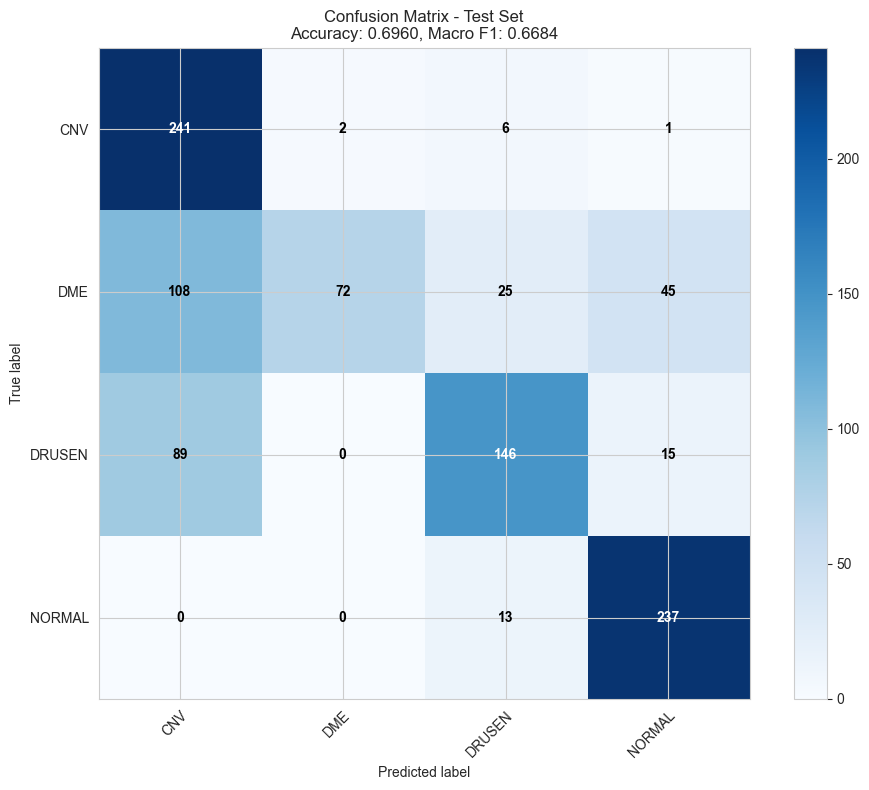


SUMMARY
Training samples (80%): 66787
Validation samples (20%): 16697
Test samples (val + test merged): 1000

Validation Accuracy (20% holdout): 0.7833
Test Accuracy (val + test): 0.6960

Test F1 Scores:
  Micro F1:    0.6960
  Macro F1:    0.6684
  Weighted F1: 0.6684

Training time: 103.96s

All done!


In [12]:
# Load evaluation images (val + test merged)
print("\n" + "=" * 60)
print("LOADING EVALUATION SET (VAL + TEST MERGED)")
print("=" * 60)
X_eval_list = []
eval_indices = np.arange(len(eval_paths))
for batch_imgs, batch_idxs in tqdm(
        batch_iterator(eval_paths, eval_indices, batch_size=BATCH_SIZE),
        total=(len(eval_paths) + BATCH_SIZE - 1) // BATCH_SIZE,
        desc="Loading eval"
):
    X_eval_list.append(batch_imgs)

X_eval = np.concatenate(X_eval_list, axis=0)
print(f"X_eval shape: {X_eval.shape}")
del X_eval_list
gc.collect()

# Final evaluation on test set (val + test merged)
print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET (VAL + TEST MERGED)")
print("=" * 60)

# Predict on evaluation set
y_eval_pred = pipeline.predict(X_eval)
eval_acc = accuracy_score(y_eval, y_eval_pred)
print(f"Test Accuracy: {eval_acc:.4f}")

# Classification report with F1 scores
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("\nClassification Report:")
class_names = [name for name, _ in sorted(label_map.items(), key=lambda x: x[1])]
print(classification_report(y_eval, y_eval_pred, target_names=class_names))

# Overall F1 scores
f1_micro = f1_score(y_eval, y_eval_pred, average='micro')
f1_macro = f1_score(y_eval, y_eval_pred, average='macro')
f1_weighted = f1_score(y_eval, y_eval_pred, average='weighted')

print(f"\nF1 Scores:")
print(f"  Micro F1:    {f1_micro:.4f}")
print(f"  Macro F1:    {f1_macro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_eval, y_eval_pred)
print(cm)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       title=f'Confusion Matrix - Test Set\nAccuracy: {eval_acc:.4f}, Macro F1: {f1_macro:.4f}',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black",
                fontsize=10, fontweight='bold')

fig.tight_layout()
plt.savefig('confusion_matrix_test.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved to 'confusion_matrix_test.png'")
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Training samples (80%): {len(train_idx)}")
print(f"Validation samples (20%): {len(val_idx)}")
print(f"Test samples (val + test merged): {len(eval_paths)}")
print(f"\nValidation Accuracy (20% holdout): {val_acc:.4f}")
print(f"Test Accuracy (val + test): {eval_acc:.4f}")
print(f"\nTest F1 Scores:")
print(f"  Micro F1:    {f1_micro:.4f}")
print(f"  Macro F1:    {f1_macro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")
print(f"\nTraining time: {train_time:.2f}s")
print("=" * 60)
print("\nAll done!")
print("=" * 60)

In [15]:
#HOG + SIFT
print("\n\n" + "=" * 60)
print("TRAINING HOG+SIFT MODEL")
print("=" * 60)

# Build HOG+SIFT pipeline using the HOGSIFTConcatTransformer
print("Building HOG+SIFT pipeline...")
print("HOG params: orientations=12, pixels_per_cell=(16,16), cells_per_block=(2,2)")
print("SIFT params: n_features=0, contrastThreshold=0.02, edgeThreshold=15.0, sigma=1.2")

pipeline_hogsift = Pipeline([
    ('hogsift', HOGSIFTConcatTransformer(
        hog_params={
            'orientations': 12,
            'pixels_per_cell': (16, 16),
            'cells_per_block': (2, 2),
            'block_norm': 'L2-Hys'
        },
        sift_params={
            'n_features': 0,
            'contrastThreshold': 0.02,
            'edgeThreshold': 15.0,
            'sigma': 1.2
        },
        hog_weight=1.0,
        sift_weight=1.0
    )),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=256, random_state=RANDOM_STATE)),
    ('svm', LinearSVC(
        C=0.25,
        class_weight=class_weight_dict,
        max_iter=5000,
        random_state=RANDOM_STATE,
        dual='auto'
    ))
])

# Train HOG+SIFT model
print("\nTraining HOG+SIFT model...")
start_time_hs = time.time()
pipeline_hogsift.fit(X_train, y_train)
train_time_hs = time.time() - start_time_hs
print(f"Training completed in {train_time_hs:.2f}s")

# Evaluate on training holdout (20%)
print("\n" + "=" * 60)
print("EVALUATION ON TRAINING HOLDOUT (20%) - HOG+SIFT")
print("=" * 60)
y_val_pred_hs = pipeline_hogsift.predict(X_val)
val_acc_hs = accuracy_score(y_val, y_val_pred_hs)
print(f"Validation Accuracy: {val_acc_hs:.4f}")

print("\nClassification Report (Training Holdout):")
print(classification_report(y_val, y_val_pred_hs, target_names=class_names))

# Save HOG+SIFT model (handle cv2.SIFT unpicklable issue)
model_save_path_hs = "hogsift_oct_model.joblib"
print(f"\nSaving HOG+SIFT model to {model_save_path_hs}...")

# Temporarily remove the SIFT object before saving
sift_transformer = pipeline_hogsift.named_steps['hogsift']._sift
sift_obj = sift_transformer._sift
sift_transformer._sift = None  # Remove unpicklable cv2.SIFT object

try:
    dump(pipeline_hogsift, model_save_path_hs)
    print("Model saved successfully!")
finally:
    # Restore the SIFT object for continued use
    sift_transformer._sift = sift_obj



TRAINING HOG+SIFT MODEL
Building HOG+SIFT pipeline...
HOG params: orientations=12, pixels_per_cell=(16,16), cells_per_block=(2,2)
SIFT params: n_features=0, contrastThreshold=0.02, edgeThreshold=15.0, sigma=1.2

Training HOG+SIFT model...
Training completed in 270.72s

EVALUATION ON TRAINING HOLDOUT (20%) - HOG+SIFT
Validation Accuracy: 0.8213

Classification Report (Training Holdout):
              precision    recall  f1-score   support

         CNV       0.90      0.89      0.89      7441
         DME       0.79      0.79      0.79      2270
      DRUSEN       0.48      0.48      0.48      1723
      NORMAL       0.83      0.86      0.85      5263

    accuracy                           0.82     16697
   macro avg       0.75      0.75      0.75     16697
weighted avg       0.82      0.82      0.82     16697


Saving HOG+SIFT model to hogsift_oct_model.joblib...
Model saved successfully!



FINAL EVALUATION ON TEST SET - HOG+SIFT
Test Accuracy: 0.7680

Classification Report:
              precision    recall  f1-score   support

         CNV       0.61      0.99      0.76       250
         DME       0.99      0.46      0.63       250
      DRUSEN       0.84      0.64      0.73       250
      NORMAL       0.84      0.98      0.91       250

    accuracy                           0.77      1000
   macro avg       0.82      0.77      0.76      1000
weighted avg       0.82      0.77      0.76      1000


F1 Scores:
  Micro F1:    0.7680
  Macro F1:    0.7559
  Weighted F1: 0.7559

Confusion Matrix:
[[247   0   3   0]
 [ 76 116  22  36]
 [ 79   1 161   9]
 [  0   0   6 244]]

Confusion matrix saved to 'confusion_matrix_hogsift_test.png'


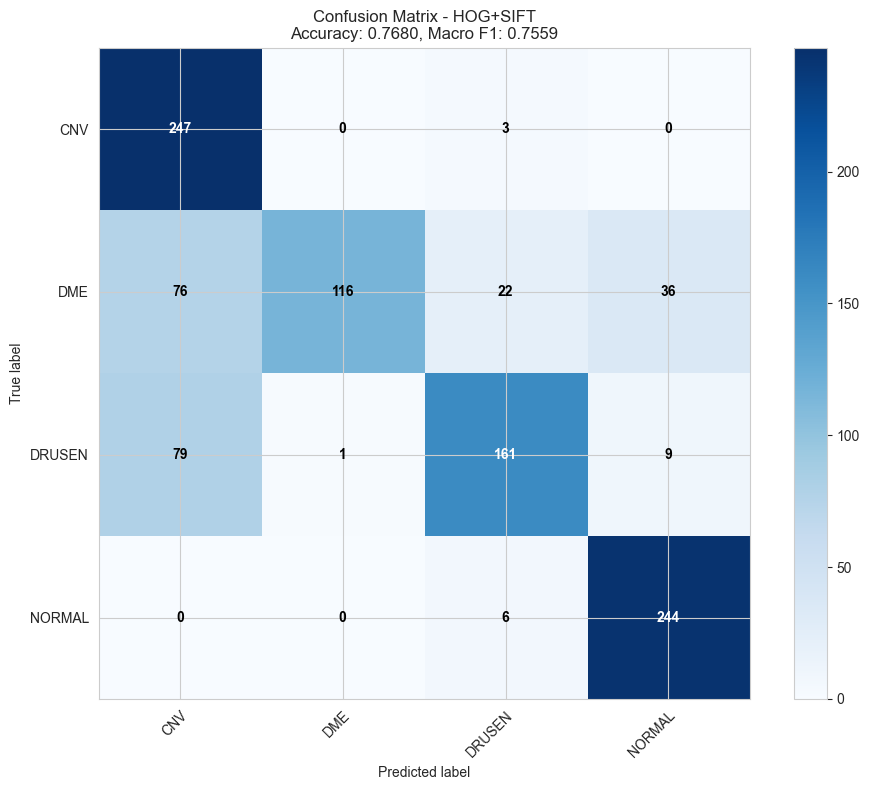


COMPARISON: HOG vs HOG+SIFT
Metric                    HOG             HOG+SIFT        Difference     
----------------------------------------------------------------------
Val Accuracy (20%)        0.7833          0.8213          +0.0380
Test Accuracy             0.6960          0.7680          +0.0720
Test Macro F1             0.6684          0.7559          +0.0875
Test Weighted F1          0.6684          0.7559          +0.0875
Training Time (s)         103.96          270.72          +166.76

All done!


In [16]:
# Evaluate HOG+SIFT on test set
print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET - HOG+SIFT")
print("=" * 60)

y_eval_pred_hs = pipeline_hogsift.predict(X_eval)
eval_acc_hs = accuracy_score(y_eval, y_eval_pred_hs)
print(f"Test Accuracy: {eval_acc_hs:.4f}")

print("\nClassification Report:")
print(classification_report(y_eval, y_eval_pred_hs, target_names=class_names))

# F1 scores
f1_micro_hs = f1_score(y_eval, y_eval_pred_hs, average='micro')
f1_macro_hs = f1_score(y_eval, y_eval_pred_hs, average='macro')
f1_weighted_hs = f1_score(y_eval, y_eval_pred_hs, average='weighted')

print(f"\nF1 Scores:")
print(f"  Micro F1:    {f1_micro_hs:.4f}")
print(f"  Macro F1:    {f1_macro_hs:.4f}")
print(f"  Weighted F1: {f1_weighted_hs:.4f}")

# Confusion Matrix for HOG+SIFT
print("\nConfusion Matrix:")
cm_hs = confusion_matrix(y_eval, y_eval_pred_hs)
print(cm_hs)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_hs, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm_hs.shape[1]),
       yticks=np.arange(cm_hs.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       title=f'Confusion Matrix - HOG+SIFT\nAccuracy: {eval_acc_hs:.4f}, Macro F1: {f1_macro_hs:.4f}',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(cm_hs.shape[0]):
    for j in range(cm_hs.shape[1]):
        ax.text(j, i, format(cm_hs[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_hs[i, j] > cm_hs.max() / 2. else "black",
                fontsize=10, fontweight='bold')

fig.tight_layout()
plt.savefig('confusion_matrix_hogsift_test.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved to 'confusion_matrix_hogsift_test.png'")
plt.show()

# Comparison summary
print("\n" + "=" * 60)
print("COMPARISON: HOG vs HOG+SIFT")
print("=" * 60)
print(f"{'Metric':<25} {'HOG':<15} {'HOG+SIFT':<15} {'Difference':<15}")
print("-" * 70)
print(f"{'Val Accuracy (20%)':<25} {val_acc:<15.4f} {val_acc_hs:<15.4f} {val_acc_hs - val_acc:+.4f}")
print(f"{'Test Accuracy':<25} {eval_acc:<15.4f} {eval_acc_hs:<15.4f} {eval_acc_hs - eval_acc:+.4f}")
print(f"{'Test Macro F1':<25} {f1_macro:<15.4f} {f1_macro_hs:<15.4f} {f1_macro_hs - f1_macro:+.4f}")
print(f"{'Test Weighted F1':<25} {f1_weighted:<15.4f} {f1_weighted_hs:<15.4f} {f1_weighted_hs - f1_weighted:+.4f}")
print(f"{'Training Time (s)':<25} {train_time:<15.2f} {train_time_hs:<15.2f} {train_time_hs - train_time:+.2f}")
print("=" * 60)
print("\nAll done!")
print("=" * 60)